# Univariate Time Series Model of Coal Generation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

%matplotlib inline
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import warnings
warnings.simplefilter(action="ignore")

In [2]:
df = pd.read_csv('../../data/final_dfs/combined_final.csv')

In [3]:
df

,date,Biomass,Coal,Hydro,Nuclear,Other,Solar,Wind,NGas
0,2011-01-01,1240.848016,304483.898100,670.712237,90516.910230,357.449324,70.651290,123213.388200,248086.363990
1,2011-01-02,1478.590690,320703.672600,667.009668,90462.214940,372.626928,10.255158,62531.398440,268971.649980
2,2011-01-03,1483.246127,296436.223700,741.426017,90472.370750,401.536782,15.155827,89515.573520,222285.009850
3,2011-01-04,1411.010006,322214.637700,683.281626,90312.687080,478.415477,5.278214,59542.485700,271747.936850
4,2011-01-05,1348.331266,308136.080100,623.145421,90280.191600,440.383112,22.997359,128920.842500,358001.800050
...,...,...,...,...,...,...,...,...,...
3648,2020-12-27,635.255371,184407.678785,500.494667,122762.954790,13.731479,29820.239198,321323.147861,194637.587100
3649,2020-12-28,591.302614,193621.421107,636.269588,122720.408975,-13.652177,19924.960198,350947.810220,216475.798107
3650,2020-12-29,667.202987,144900.104532,643.995831,122664.769337,-26.962775,11594.382815,443182.060206,167954.504264
3651,2020-12-30,704.598125,158272.638521,655.564849,122629.625647,19.636788,3539.284392,434953.837358,227983.660971


In [4]:
def df_converter(data, source):
    data = data[['date', source]]
    data['date']=pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)
    data['Weekly'] = data.resample('W').mean()
    data = data['Weekly'].dropna()
    data = pd.DataFrame(data)
    return data


In [5]:
df_weekly = df_converter(df, 'Solar')

In [6]:
df_weekly

,Weekly
date,
2011-01-02,40.453224
2011-01-09,42.081287
2011-01-16,12.561364
2011-01-23,37.173048
2011-01-30,83.967151
...,...
2020-11-29,17729.391108
2020-12-06,19531.384096
2020-12-13,24889.975481


<AxesSubplot:xlabel='date'>

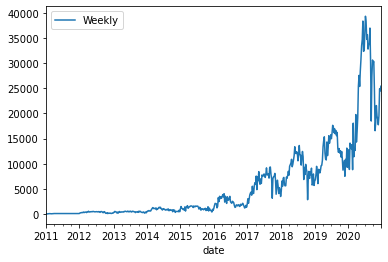

In [7]:
df_weekly.plot()

### Let's calculate the moving average

In [8]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(df_weekly, 7)

21474.006245163266

In [9]:

def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

In [10]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

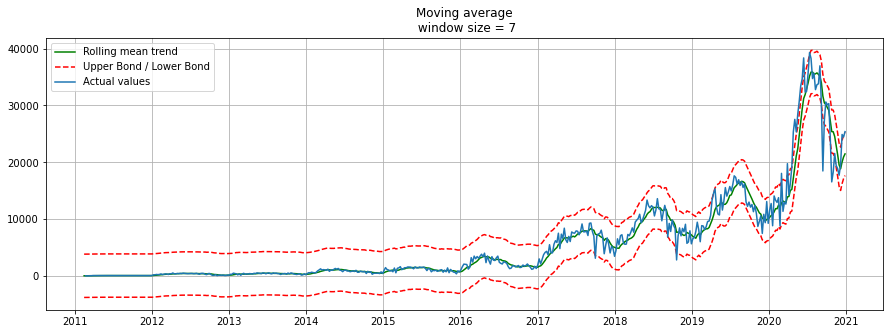

In [11]:
plotMovingAverage(df_weekly, 7, plot_intervals=True)

### A weighted average will provide a better understanding of the average with respect to more recent data

In [12]:
def wtd_ave(data, wts):
    """
        Calculate weighted average on the series.
        Assuming weights are sorted in descending order
        (larger weights are assigned to more recent observations).
    """
    result = 0.0
    for n in range(len(wts)):
        result += data.iloc[-n-1] * wts[n]
    return float(result)

In [13]:
wtd_ave(df_weekly, [0.6, 0.3, 0.1])

25055.256998814286

### Building a Model

In [14]:
def tsplot(df_weekly, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        df_weekly.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(df_weekly)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(df_weekly, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(df_weekly, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [15]:
df_weekly

,Weekly
date,
2011-01-02,40.453224
2011-01-09,42.081287
2011-01-16,12.561364
2011-01-23,37.173048
2011-01-30,83.967151
...,...
2020-11-29,17729.391108
2020-12-06,19531.384096
2020-12-13,24889.975481


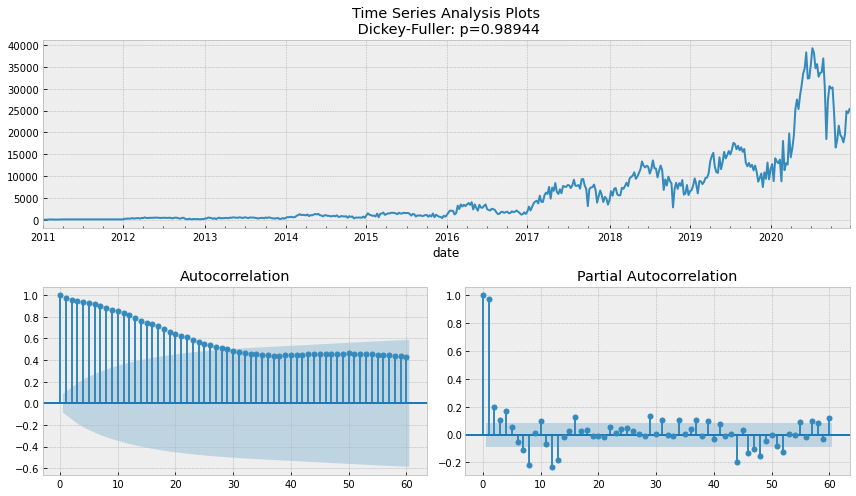

In [16]:
tsplot(df_weekly.Weekly, lags = 60)

### Take the seasonal difference

In [15]:
# coal_df_1 = df['Coal'] - df['Coal'].shift(365)

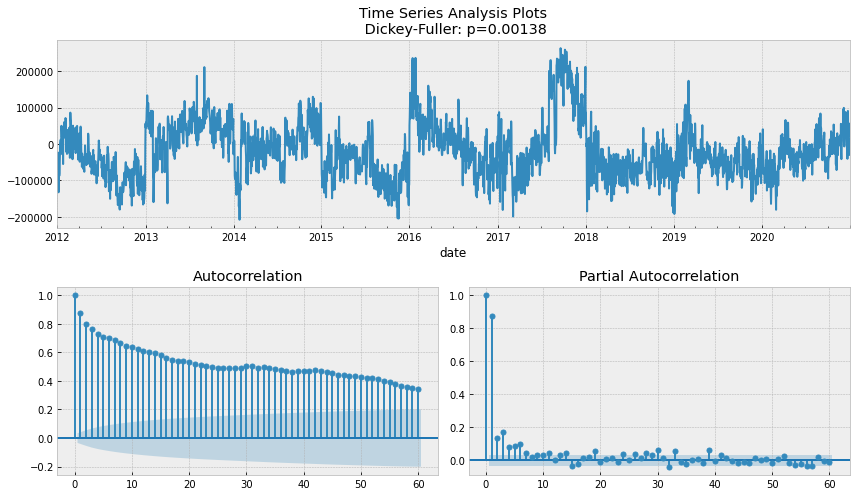

In [16]:
# tsplot(coal_df_1[365:], lags =60)

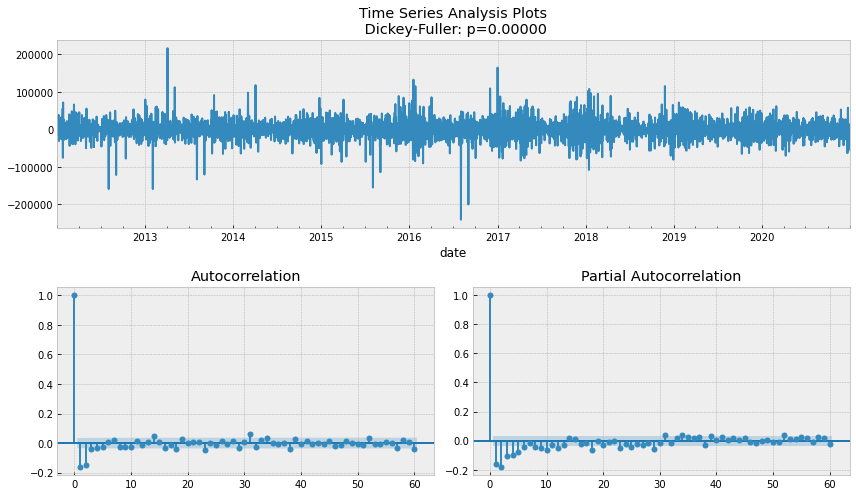

In [17]:
# coal_df_1 = df['Coal'] - df['Coal'].shift(1)
# tsplot(coal_df_1[365+1:], lags =60)

#### Optimize the parameters

In [17]:
# setting initial values and some bounds for them
ps = range(2, 4)
d=1 
qs = range(2, 4)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 52 # season length is 7 due to yearly seasonality with daily data

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [18]:

def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(df_weekly.Weekly, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [19]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


CPU times: user 25min 29s, sys: 1min 31s, total: 27min
Wall time: 16min 22s


In [20]:
result_table

,parameters,aic
0,"(3, 3, 1, 1)",8264.941144
1,"(3, 3, 0, 1)",8265.546138
2,"(2, 2, 1, 1)",8266.609524
3,"(2, 2, 0, 1)",8267.083526
4,"(2, 3, 1, 0)",8268.287411
5,"(3, 2, 1, 1)",8268.759794
6,"(3, 2, 0, 1)",8269.256231
7,"(3, 3, 1, 0)",8269.998884
8,"(2, 2, 1, 0)",8274.338617
9,"(3, 2, 1, 0)",8275.662459


In [21]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_weekly.Weekly, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               Weekly   No. Observations:                  522
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 52)   Log Likelihood               -4123.471
Date:                              Wed, 14 Apr 2021   AIC                           8264.941
Time:                                      15:57:33   BIC                           8302.297
Sample:                                  01-02-2011   HQIC                          8279.639
                                       - 12-27-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8333      0.146      5.713      0.000       0.547       1.119
ar.L2         -0.90

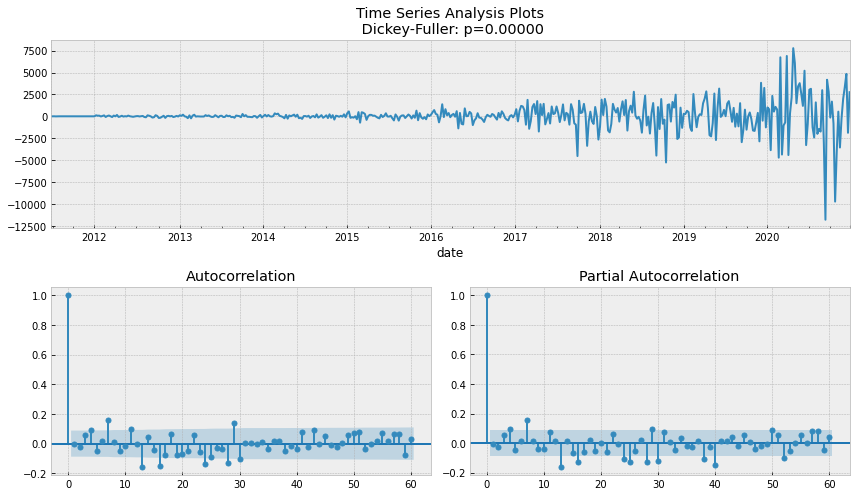

In [22]:
tsplot(best_model.resid[24+1:], lags=60)

In [23]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

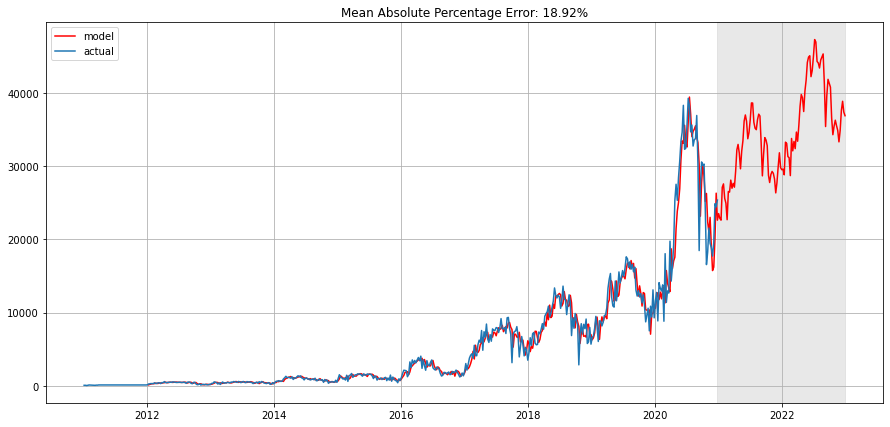

In [24]:
plotSARIMA(df_weekly, best_model, 104)
